# Basic use of beagle package

In this section an overview of the inner workings of the beagle package will be given, sufficient to address a wide range of problems using evolutionary algorithms. For more information about each of the components involved in the algorithms, it is recommended to look at each of the components of the package in more detail in each of the other sections. It is also highly recommended to check the test examples and notebooks collected in examples.

## Description of the example problem

In order to show how the module works, it is necessary to select a problem, for this purpose we will use the well-known 'knapsack' problem. This problem represents a generalization that can be applied to a wide variety of real-life problems. Considering a set of 'n' elements, each one has associated a value 'v' and a cost 'c', the objective of the problem is to select the subset of elements that maximizes the sum of the values while keeping the cost within a certain limit denoted as 'C'. In essence, it is about maximizing utility within a set of constraints.

For this problem, the candidate solutions can be represented as an array of binaries of length n, where 1 indicates that a certain item is included and 0 that this item is omitted. There are different alternatives for mapping from genotype to phenotype. In this case, the approach in which we reduce the maximum computational cost would be the following:

An individual's genotype consists of an array of binaries, in order to perform genotype-to-genotype mapping we start reading the genotype from left to right. As we read the genotype we compute the sum of the values (utility) associated with the item indicated by each position and the cost. In this way, if we exceed the limit imposed by the maximum cost value C, we stop going through the genotype and keep the items seen up to that point (the total utility of the genotype). This rule could be identified as:

**Go through the items included in the genotype accumulating the utility until the cost is exceeded.**

Consequently, the fitness value of an individual will correspond to the sum of the values of the items included. This form of mapping ensures that there will be no invalid individuals in the population.

First we have to define our items, values and cost. As I don't feel like writing it manually, I will do it randomly creating a vector of length N associated to the items, and two other vectors of the same length with the utility value and the cost respectively. For this purpose I will use the numpy library. After that, defining the fitness function is something trivial.

Here are the elements needed to represent the problem implemented:

In [1]:
import numpy as np
import sys
sys.path.append('..')   # Use beagle
import beagle as be

In [2]:
num_items = 200

# Utility values range from 1 to 10
item_utility = np.random.uniform(low=1, high=10, size=num_items)

# Cost values range from 0 to 1 
item_costs = np.random.uniform(low=0, high=1, size=num_items)

Additionally we define the fitness function as indicated in the description. It goes through the genotype of the individuals calculating the utility as long as the value of the cost is not exceeded.

In [3]:
maximum_cost = 50

def fitness_function(values) -> float:

    utility, cost = 0.0, 0.0

    for i, position in enumerate(values):

        # The item is present in the genotype
        if position == 1:  
            if cost < maximum_cost:
                utility += item_utility[i]
                cost += item_costs[i]

            # The maximum cost allowed is exceeded
            else:  
                return utility

    return utility

Once these components are defined we can use all the functionalities and facilities implemented in the beagle module to optimize the problem.

## Algorithm interface

The genetic algorithms are executed through the Algorithm class. There are two options for the creation of an object belonging to the Algorithm class each with its advantages and disadvantages. The first alternative is to define a step function and pass it to the constructor of the Algorithm class. This step function, as described later, should define the different steps carried out by the algorithm for which the different operators provided by the Beagle package can be used. The second alternative is to use predefined algorithms, in this case it is not necessary to define a step function since there are different step functions already predefined in beagle that can be used automatically. Additionally, in both strategies it will be necessary to define a population (or at least indicate to the class the necessary parameters to define one) and a fitness object.

These two ways of defining an Algorithm object will be described in more detail below. Each of the two alternatives has its strengths and weaknesses. On the one hand, the definition of the step function gives the user enormous flexibility when it comes to experimenting with different strategies. However, this strategy will also require more lines of code, code that may be more error-prone. On the other hand, the use of pre-defined algorithms allows the user an easy and intuitive use of the module requiring fewer lines of code and therefore with a lower tendency to introduce errors. Conversely, the use of pre-defined algorithms reduces flexibility in designing evolutionary algorithms.

To understand a little more in detail how the beagle package works we will start with the second alternative, the simplest and most intuitive (useful for most problems) and then it will be presented how to define the step functions for a more fine tuned use of the module.

### Using pre-defined algorithms

As mentioned above, the beagle module incorporates several predefined algorithms, this functionality makes extremely simple the use of evolutionary algorithms. As shown in the following example, the use of these algorithms is quite straightforward. Using the fitness function defined above, creating and executing an algorithm is as simple as that:

In [4]:
# Population of 100 individuals (binary representation)
size = 100
representation='binary'


# Creation of a fitness object using the function defined above
fitness_obj = be.Fitness(fitness_function)

# There are several schemes available, in this example we use the GA1 scheme
alg_schema = 'GA1'

# In this case it is necessary to specify the arguments required by the representation, 
#  for binary representations the length of the vector
pre_defined_alg = be.use_algorithm('GA1', 
                                   fitness=fitness_obj, 
                                   population_size=size, 
                                   individual_representation=representation, 
                                   length=num_items)

# ... and execute the algorithm for 100 generations
pre_defined_alg.run(100)

(1609081578.488348) Generations : 100%|██████████| 100/100 [00:16<00:00,  6.06it/s]


Optionally it is possible to create the population separately and pass it to the function directly using the initial_population argument.

In [5]:
population = be.Population(size=100, representation='binary', length=num_items)

pre_defined_alg = be.use_algorithm('GA1', 
                                   fitness=fitness_obj, 
                                   initial_population=population)

It is possible to see all the predefined algorithms in beagle and the steps they perform.

In [6]:
# See the name of the predefined algorithms
be.AVAILABLE_BUILDINGS.keys()

dict_keys(['GA1', 'GA2', 'NSGA2', 'SPEA2'])

In [7]:
# See detailed description for a specific algorithm ('GA1')
help(be.AVAILABLE_BUILDINGS['GA1'])

Help on function basic_ga_1 in module beagle.building.basic:

basic_ga_1(parents: beagle.population.Population, fitness_function: beagle.fitness.Fitness, **kwargs)
    Scheme of the step function of a basic genetic algorithm The steps followed by this scheme are:
    
    1. recombination(parents) -> Offspring (length == parents)
    2. mutation(offspring)
    3. evaluation(offspring)
    4. parents + offspring -> population
    5. selection(population) -> parents (and create a report)
    
    Used operators:
    
        - beagle.mutation(): Default schemas:
            Binary representation: bit_flip
            Integer representation: random_resetting
            Real representation: uniform_mutation
            Permutation representation: inversion_mutation
    
        To use a different schema from the default ones it is possible to specify an optional argument
        mutation with the schema name. On the other hand, to change specific parameters of mutation
        operators (

### Fine-tuning of the algorithm

Warning !!!: *Not understanding the parameters used in the algorithms shown below is normal if you are not familiar with the components of evolutionary algorithms, especially the operators. It is therefore recommended to review the rest of sections before venturing to play with the different parameters available. In addition, a basic knowledge of evolutionary algorithms and techniques is also recommended. This section has been designed with the objective of showing the beagle dynamics, therefore the parameters used are in many cases are irrelevant.*

The different predefined algorithms make use of different operators. These operators in turn have a number of hyperparameters that the user can play with in order to obtain a fine tuning of the algorithm. For the recombination and mutation operators the available operators will depend on the type of representation used. For more information about the operators it is recommended to consult the sections on mutation and recombination operators. To change the default scheme you can simply specify the mutation and recombination arguments respectively specifying the operator to be used. On the other hand, each operator has a number of parameters that can be changed. To change the default parameters of an operator it is necessary to specify the type of operation to be performed (mutation or recombination) and the argument to be changed as shown in the following example. This is necessary to avoid ambiguity and for clarity of code.

In the following example we will change the recombination scheme, by default one-point recombination, to n-point recombination with 2 cut points specified by the argument recombination_cut_points. Additionally we will also increase the mutation rate by the argument mutation_probability:

In [8]:
# In this case we have specified an id for the algorithm, something optional
pre_defined_alg = be.use_algorithm('GA1', 
                                   fitness=fitness_obj, 
                                   initial_population=population, 
                                   alg_id='GA1', 
                                   recombination='n_point_b', 
                                   recombination_cut_points=2, 
                                   mutation_probability=0.2)

The use of different selection operators will depend on the algorithm to be used. For example, currently mono-objective evolutionary algorithm builds 'GA1' and 'GA2' are available. In 'GA1' it is possible to specify the selection type to be used by the selection parameter, the selection scheme within the selected selection type by the selection_schema parameter and additional parameters by the scheme name and parameter name for example:

In [9]:
pre_defined_alg = be.use_algorithm('GA1', 
                                   fitness=fitness_obj, 
                                   initial_population=population, 
                                   selection='proportional',
                                   selection_schema='sigma_scaling',
                                   selection_c=1.5)

The example uses one of the schemes of the fitness proportional selection by changing the parameter c associated with the sigma scaling selection operator to 1.5.


Another example using the classic roulette selection operator:

In [10]:
pre_defined_alg = be.use_algorithm('GA1', 
                                   fitness=fitness_obj, 
                                   initial_population=population, 
                                   selection='ranking',
                                   selection_schema='roulette',
                                   selection_rank_schema='exponential')

On the other hand, the 'GA2' construction uses the tournament selection operator with the generally used parameters by default. This operator is one of the most recommended for most problems. It is also the default operator for the 'GA1' build, although in this other build it is possible to change it while in 'GA2' it is not.


Additionally, the 'GA2' construction incorporates the use of Survivor selection operator (Annihilation and Elitism). These operators include strategies of selection and annihilation of the population based on their fitness values. Again, the recombination and mutation parameters can be changed as shown in the previous examples. Let's see what we can do with this build through examples. For instance, we can increase the values of elitism and annihilation from 0.1 (default value) to 0.2:

In [11]:
pre_defined_alg = be.use_algorithm('GA2', 
                                   fitness=fitness_obj, 
                                   initial_population=population, 
                                   elitism_select=0.2,
                                   annihilation_annihilate=0.2)

Or change the different parameters of the tournament selection:

In [12]:
pre_defined_alg = be.use_algorithm('GA2', 
                                   fitness=fitness_obj, 
                                   initial_population=population, 
                                   tournament_k=10,
                                   tournament_w=5,
                                   tournament_replacement=True)

And of course we can also play with the mutation and recombination parameters as we did before.

In [13]:
pre_defined_alg = be.use_algorithm('GA2', 
                                   fitness=fitness_obj, 
                                   initial_population=population, 
                                   recombination='uniform_b',
                                   recombination_probability=0.75,
                                   mutation_probability=0.05)

### Displaying convergence

To see the convergence of the algorithm it is possible to use the display function. It is possible to call this function by specifying a path where the generated graphic will be saved. If this parameter is not specified beagle will automatically create the file directly in the current directory. If you do not want to generate a file it is possible to specify an only_show argument as True to indicate that the graphic will not be saved and will be automatically displayed.

In [14]:
# Population of 100 individuals (binary representation)
size = 100
representation='binary'


# Creation of a fitness object using the function defined above
fitness_obj = be.Fitness(fitness_function)

# There are several schemes available, in this example we use the GA1 scheme
alg_schema = 'GA1'

# In this case it is necessary to specify the arguments required by the representation, 
#  for binary representations the length of the vector
pre_defined_alg = be.use_algorithm('GA1', 
                                   fitness=fitness_obj, 
                                   population_size=size, 
                                   individual_representation=representation, 
                                   length=num_items)

# ... and execute the algorithm for 100 generations
pre_defined_alg.run(100)

(1609081578.488348) Generations : 100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


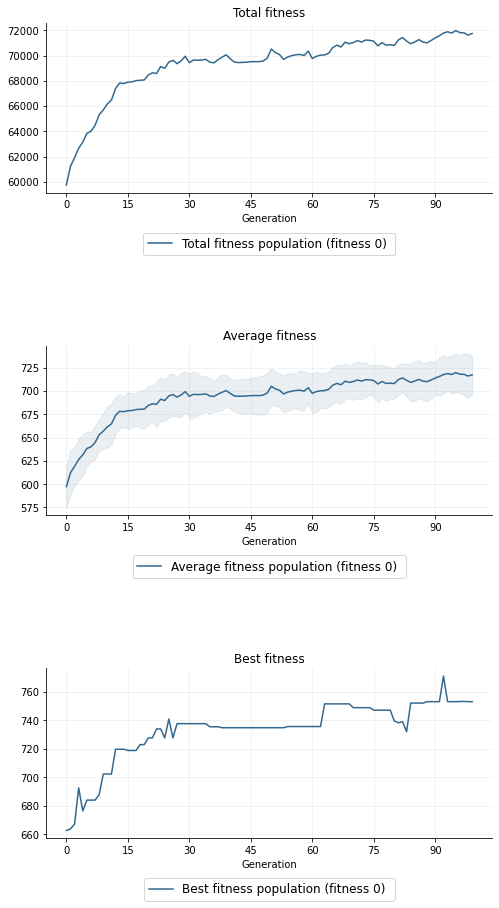

In [15]:
be.display(pre_defined_alg, path='./ToyExample.pdf')

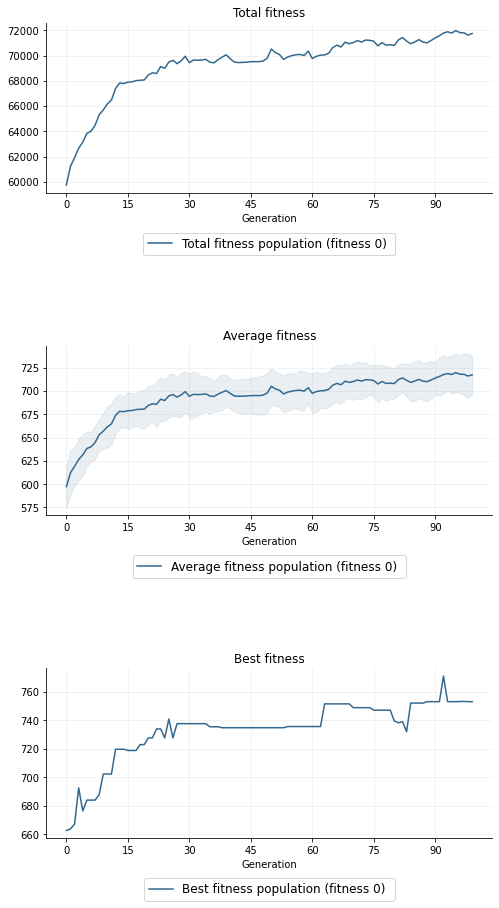

In [16]:
# Or to show convergence directly
be.display(pre_defined_alg, only_show=True)

## Defining the step function

As mentioned above, this is the alternative that provides the user with more flexibility. In this strategy the user must create a function defining the different steps carried out by the algorithm in each generation as shown below. This step function is used to create an object of the class Algorithm (in essence the function use_algorithm shown in the previous section returns an object of the class Algorithm) through which it will be possible to carry out the optimization of the objective fitness function or functions.

In the following codes the fitness function defined at the beginning of the section will be used again. The step function will always receive a population as the first argument and a fitness object as the second. Optionally it can receive any number of arbitrary parameters. The function will return a tuple where the first element will necessarily be the population that will pass to the next generation and optionally the second will be a Report object or None. For example, the following step function performs the following steps:

1. Select an elite of individuals from population -> Elite
2. Apply tournament selection to population selecting the mating pool -> Mating pool.
3. Apply One-point cross over to the mating pool -> Offspring.
4. Mutate offspring.
5. Evaluate offspring.
6. Merge elite and offspring -> Next generation.

In [17]:
def step(parents: be.Population, fitness: be.Fitness, **kwargs) -> tuple:

    # Get elite (10% of the population)
    elite = be.survivor_selection(population=parents, schema='elitism', select=0.1)

    # Apply tournament selection to get the mating pool 
    # (two participants per tournament, one winner and sampling without replacement)
    mating_pool = be.ranking_selection(
        population=parents, n=len(parents) - len(elite), schema='tournament',
        w=1, k=2, replacement=False)

    # Generate offspring using one-point cross over for binary representation
    offspring = be.recombination(
        population=mating_pool, n=len(mating_pool), schema='one_point_b')

    # Mutate offspring with probability 0.1
    be.mutation(population=offspring, probability=0.1, schema='bit_flip')

    # Carry out the evaluation of the offspring in parallel
    be.evaluate_parallel(population=offspring, fitness_function=fitness)

    # Merge elite and offspring
    next_generation = be.merge_populations(offspring, elite)
    
    return next_generation, None

The code is quite explanatory, note that in this case the evaluation of individuals has been carried out in parallel to speed up the execution of the algorithm, however, in certain circumstances this may not be the most efficient option, for example if the population is small and the fitness function takes very little time to run, in this situation the evaluation in parallel may not be the best option. However, for most cases it will be. If you do not want to run the evaluation in parallel you can simply use the evaluate() function. Another aspect that can be highlighted from the code is the return of the function, as said before the first argument will always be the population that will pass to the next generation and as second argument you could pass Report objects, in this case, for simplicity, it has been preferred not to use any Report object and therefore None has been returned.

Once we have defined the step function we can proceed to the creation of an object of the class Algorithm to perform the optimization.

In [18]:
population = be.Population(size=100, representation='binary', length=num_items)

alg_obj = be.Algorithm(step=step, 
                       fitness=fitness_obj,
                       initial_population=population)

# ... and execute the algorithm
alg_obj.run(100)

(1609081578.488348) Generations : 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


In the example above an object of the class Algorithm has been created using a population, however it is also possible to create an object Algorithm specifying the parameters necessary for the creation of the population.

In [19]:
alg_obj = be.Algorithm(step=step,
                       fitness=fitness_obj,
                       population_size=100,
                       individual_representation='binary',
                       length=num_items)

Going back to the step function defined above, notice that we perform the tournament selection directly on the incoming population, so how is it possible to do this if this population has no fitness value assigned? The answer is simple, the class algorithm evaluates the initial population before starting to iterate over the number of generations specified using the step function. If by some chance we don't want it to perform this initial evaluation we can specify the parameter evaluate_out_of_step as False (default is True) and the Algorithm object will not perform this first evaluation.

### Using Report and Indicator objects

With the definition of the previous step function the only thing we can do is to execute the algorithm during X generations and finally access the population resulting from the last generation something that perhaps is not very useful to us. This is where the Indicator and Report objects come into play.

Report objects allow us to monitor the evolution of populations over different generations. As for the Indicator objects, these allow us to indicate that a solution has been found, that the best solution for a certain generation will be saved, or that the algorithm should be early stopped because a certain criterion has already been met.

Let's first start by creating and incorporating a Report object into the step function defined above.

In [20]:
def step(parents: be.Population, fitness: be.Fitness, **kwargs) -> tuple:

    # Get elite (10% of the population)
    elite = be.survivor_selection(population=parents, schema='elitism', select=0.1)

    # Apply tournament selection to get the mating pool 
    # (two participants per tournament, one winner and sampling without replacement)
    mating_pool = be.ranking_selection(
        population=parents, n=len(parents) - len(elite), schema='tournament',
        w=1, k=2, replacement=False)

    # Generate offspring using one-point cross over for binary representation
    offspring = be.recombination(
        population=mating_pool, n=len(mating_pool), schema='one_point_b')

    # Mutate offspring with probability 0.1
    be.mutation(population=offspring, probability=0.1, schema='bit_flip')

    # Carry out the evaluation of the offspring in parallel
    be.evaluate_parallel(population=offspring, fitness_function=fitness)

    # Merge elite and offspring
    next_generation = be.merge_populations(offspring, elite)
    
    return next_generation, None
    # Using the Report object DEFINED AS GLOBAL VARIABLE
    report.create_report(population=next_generation, 
                         population_name='Population', 
                         increment_generation=True)

    return next_generation, None
    

# Create a Report object
report = be.Report()

# ...
alg_obj = be.Algorithm(step=step, 
                       fitness=fitness_obj,
                       initial_population=population)

alg_obj.run(100)

(1609081578.488348) Generations : 100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Both creating and using Report objects is simple. We only have to create an object in the global scope of the code (i.e. where all the code to be executed is written) and use the create_report method indicating the population, the name we want to give to that population and if we want to increase the generation.

Alternatively, if we do not want to create the Report object in the global scope we can pass it to the Algorithm class constructor and access it in the step function through the optional arguments received by the fitness function. Following this strategy we can retrieve the Report object through the report property of the Algorithm class.

In [21]:
def step(parents: be.Population, fitness: be.Fitness, **kwargs) -> tuple:

    # Get elite (10% of the population)
    elite = be.survivor_selection(population=parents, schema='elitism', select=0.1)

    # Apply tournament selection to get the mating pool 
    # (two participants per tournament, one winner and sampling without replacement)
    mating_pool = be.ranking_selection(
        population=parents, n=len(parents) - len(elite), schema='tournament',
        w=1, k=2, replacement=False)

    # Generate offspring using one-point cross over for binary representation
    offspring = be.recombination(
        population=mating_pool, n=len(mating_pool), schema='one_point_b')

    # Mutate offspring with probability 0.1
    be.mutation(population=offspring, probability=0.1, schema='bit_flip')

    # Carry out the evaluation of the offspring in parallel
    be.evaluate_parallel(population=offspring, fitness_function=fitness)

    # Merge elite and offspring
    next_generation = be.merge_populations(offspring, elite)
    
    # Accessing the Report object passed as an argument to the algorithm constructor
    kwargs['report'].create_report(population=next_generation, 
                                   population_name='Population', 
                                   increment_generation=True)

    return next_generation, None
    

# Create a Report object
report = be.Report()

# ...
alg_obj = be.Algorithm(step=step, 
                       fitness=fitness_obj,
                       initial_population=population,
                       # Passing the Report object in the constructor
                       report=report)

alg_obj.run(100)

# Access to the report
alg_obj.report

(1609081578.488348) Generations : 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]


What does the create_report() method do? What it does is save the indicated population, for example we can save all the populations we want every 10 generations by accessing the 'current_generation' parameter of the optional parameters received by the step function. This is especially useful if we want to make better use of the computer memory in runs with many generations where we are not interested in saving absolutely all the generations. It can also be useful to monitor intermediate populations such as the fitness value of the elite.

In [22]:
def step(parents: be.Population, fitness: be.Fitness, **kwargs) -> tuple:

    # Get elite (10% of the population)
    elite = be.survivor_selection(population=parents, schema='elitism', select=0.1)

    # Apply tournament selection to get the mating pool 
    # (two participants per tournament, one winner and sampling without replacement)
    mating_pool = be.ranking_selection(
        population=parents, n=len(parents) - len(elite), schema='tournament',
        w=1, k=2, replacement=False)

    # Generate offspring using one-point cross over for binary representation
    offspring = be.recombination(
        population=mating_pool, n=len(mating_pool), schema='one_point_b')

    # Mutate offspring with probability 0.1
    be.mutation(population=offspring, probability=0.1, schema='bit_flip')

    # Carry out the evaluation of the offspring in parallel
    be.evaluate_parallel(population=offspring, fitness_function=fitness)

    # Merge elite and offspring
    next_generation = be.merge_populations(offspring, elite)

    if kwargs['current_generation'] % 10 == 0:  # Save each 10 generations
        # Using Report as global variable
        report.create_report(population=elite, population_name='Elite')

        report.create_report(population=next_generation, 
                             population_name='Population', 
                             increment_generation=True)

    return next_generation, None

# Algorithm parameters
generations = 200
population_size = 500
representation = 'binary'

# Create population
initial_population = be.Population(size=population_size, 
                                   representation=representation, 
                                   length=num_items)

# Create fitness function
fitness_obt = be.Fitness(fitness_function)

# Create a Report object to monitor the fitness of populations 
report = be.Report()

# Create algorithm
alg_obj = be.Algorithm(step=step, 
                       fitness=fitness_obj, 
                       initial_population=initial_population, 
                       alg_id='KnapsackProblem')

# ... execute the algorithm
alg_obj.run(generations)

(KnapsackProblem) Generations : 100%|██████████| 200/200 [00:46<00:00,  4.28it/s]


Note that in the previous example within the optional parameters when saving the first population the parameter increment_generation was not indicated, this is because if we had indicated this argument as true the Report object would have increased its current generation and would have saved the two populations in two different generations.

Addictionally, as indicated, populations have been saved every 10 generations so the convergence graph would be something like this:

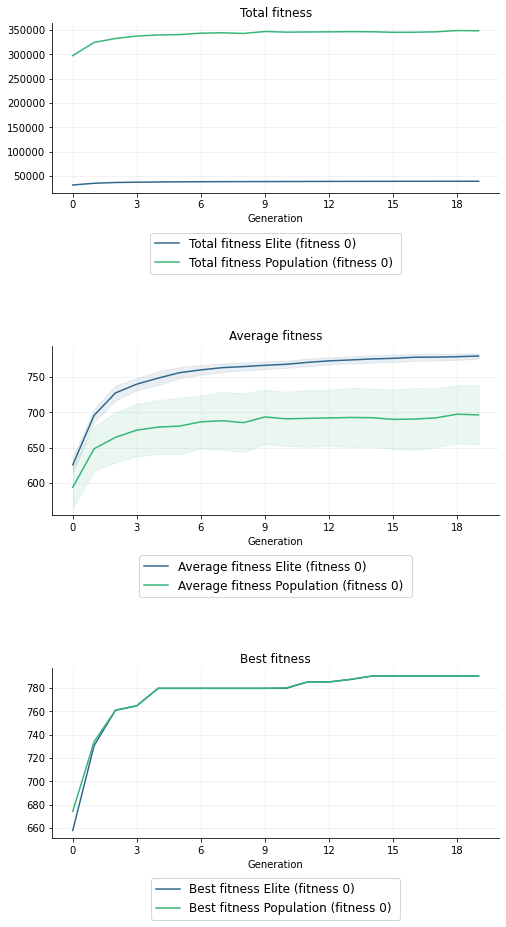

In [23]:
be.display(report, only_show=True)

The execution has been carried out for 200 generations, however, by saving the population every 10 generation in the X axis we really should multiply the generation number by 10. As expected, the fitness of the elite has remained above the fitness of the population increasing in each generation. Monitoring the evolution of the elite is quite useful, since, for example, we can check if our population has become saturated with only elite individuals, losing heterogeneity.

#### Indicator objects

On the other hand, as indicated above, Indicator objects are very useful in the execution of genetic algorithms. Currently the available Indicator objects are:

* EarlyStopping: Allows an early stop of the algorithm.

* SolutionFound: Indicates that a solution has been found.

* SaveBestSolution: Saves the best solution of a certain population.

The following shows how to use these indicators based on the above code with a slight modification to the step function

In [24]:
def step(parents: be.Population, fitness: be.Fitness, **kwargs) -> tuple:

    # Get elite (10% of the population)
    elite = be.survivor_selection(population=parents, schema='elitism', select=0.1)

    # Apply tournament selection to get the mating pool 
    # (two participants per tournament, one winner and sampling without replacement)
    mating_pool = be.ranking_selection(
        population=parents, n=len(parents) - len(elite), schema='tournament',
        w=1, k=2, replacement=False)

    # Generate offspring using one-point cross over for binary representation
    offspring = be.recombination(
        population=mating_pool, n=len(mating_pool), schema='one_point_b')

    # Mutate offspring with probability 0.1
    be.mutation(population=offspring, probability=0.1, schema='bit_flip')

    # Carry out the evaluation of the offspring in parallel
    be.evaluate_parallel(population=offspring, fitness_function=fitness)

    # Merge elite and offspring
    next_generation = be.merge_populations(offspring, elite)

    return next_generation, be.SaveBestSolution(next_generation)



# Algorithm parameters
generations = 200
population_size = 500
representation = 'binary'

# Create population
initial_population = be.Population(size=population_size, 
                                   representation=representation, 
                                   length=num_items)

# Create fitness function
fitness_obt = be.Fitness(fitness_function)

# Create a Report object to monitor the fitness of populations 
report = be.Report()

# Create algorithm
alg_obj = be.Algorithm(step=step, 
                       fitness=fitness_obj, 
                       initial_population=initial_population, 
                       alg_id='KnapsackProblem')

# ... execute the algorithm
alg_obj.run(generations)

(KnapsackProblem) Generations : 100%|██████████| 200/200 [00:46<00:00,  4.35it/s]


In this way it is possible to access the solutions found through the solutions method:

In [25]:
alg_obj.solutions()  # Get the best solution in each generation

[Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=binary),
 Individual(representation=b

Let's see how the best solution evolves over the generations...

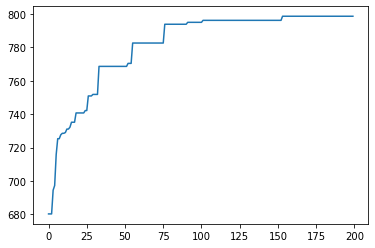

In [26]:
import matplotlib.pyplot as plt

x = [n for n in range(len(alg_obj.solutions()))]
y = [solution.fitness[0] for solution in alg_obj.solutions()]

plt.plot(x, y)
plt.show()

To get the best solution it is possible to specify the only_best argument as True.

In [27]:
alg_obj.solutions(only_best=True)

[Individual(representation=binary)]

In the case of requiring an early stop because a criterion established by the user has been met, the EarlyStopping indicator will stop the execution of the algorithm. The solution that has met this criterion can be accessed by the solutions() method.

In [28]:
def step(parents: be.Population, fitness: be.Fitness, **kwargs) -> tuple:

    # Get elite (10% of the population)
    elite = be.survivor_selection(population=parents, schema='elitism', select=0.1)

    # Apply tournament selection to get the mating pool 
    # (two participants per tournament, one winner and sampling without replacement)
    mating_pool = be.ranking_selection(
        population=parents, n=len(parents) - len(elite), schema='tournament',
        w=1, k=2, replacement=False)

    # Generate offspring using one-point cross over for binary representation
    offspring = be.recombination(
        population=mating_pool, n=len(mating_pool), schema='one_point_b')

    # Mutate offspring with probability 0.1
    be.mutation(population=offspring, probability=0.1, schema='bit_flip')

    # Carry out the evaluation of the offspring in parallel
    be.evaluate_parallel(population=offspring, fitness_function=fitness)

    # Merge elite and offspring
    next_generation = be.merge_populations(offspring, elite)
    
    # Early stopping criterion: Fitness > 700
    for individual in next_generation:
        if individual.fitness[0] > 700:
            return next_generation, be.EarlyStopping(individual)

    return next_generation, None

# Algorithm parameters
generations = 200
population_size = 500
representation = 'binary'

# Create population
initial_population = be.Population(size=population_size, 
                                   representation=representation, 
                                   length=num_items)

# Create fitness function
fitness_obt = be.Fitness(fitness_function)

# Create a Report object to monitor the fitness of populations 
report = be.Report()

# Create algorithm
alg_obj = be.Algorithm(step=step, 
                       fitness=fitness_obj, 
                       initial_population=initial_population, 
                       alg_id='KnapsackProblem')

# ... execute the algorithm
alg_obj.run(generations)

(KnapsackProblem) Generations :   2%|▎         | 5/200 [00:01<00:52,  3.72it/s]

Early stopping in generation 5 of 200


In [29]:
alg_obj.solutions()[0].values

array([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1])

In case you want to search for different solutions you can use the SolutionFound indicator, this will save the solution found but will not stop the algorithm. This is the only difference to the EarlyStopping indicator which does stop the algorithm.